Proximity Analysis of MLB Stadiums to Census Tracts

Load and merge census tract data

In [9]:
import pygris
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

# List of state FIPS codes, excluding Alaska and Hawaii
state_fips_codes = [
    '01', '04', '05', '06', '08', '09', '10', '11', '12', '13', '16', '17', '18', '19', '20', '21', '22', '23', 
    '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '44', 
    '45', '46', '47', '48', '49', '50', '51', '53', '54', '55', '56'
]

# Initialize an empty GeoDataFrame
all_census_tracts = gpd.GeoDataFrame()

# Loop through each state and pull the census tract data
for fips in state_fips_codes:
    state_tracts = pygris.tracts(state=fips, year=2020)
    all_census_tracts = pd.concat([all_census_tracts, state_tracts], ignore_index=True)

# Set the CRS for the census tracts if not already set
if all_census_tracts.crs is None:
    all_census_tracts.set_crs(epsg=4326, inplace=True)

# Load the stadium data
stadium_csv_path = '/Users/mitchellhamilton/m-r-ham.github.io/mitchymaps.github.io/projects/mlb-analysis/data/mlb_stadiums_geocoded.csv'  # Update with actual file path
stadiums = pd.read_csv(stadium_csv_path)

# Convert to GeoDataFrame
stadiums['geometry'] = stadiums.apply(lambda row: Point(row['Longitude'], row['Latitude']), axis=1)
stadiums_gdf = gpd.GeoDataFrame(stadiums, geometry='geometry')

# Set the CRS for the stadiums if not already set
if stadiums_gdf.crs is None:
    stadiums_gdf.set_crs(epsg=4326, inplace=True)

print("Census tracts and stadiums data loaded with CRS set.")

Census tracts and stadiums data loaded with CRS set.


In [10]:
# Reproject the census tracts and stadiums to EPSG:3857 for distance calculations
all_census_tracts = all_census_tracts.to_crs(epsg=3857)
stadiums_gdf = stadiums_gdf.to_crs(epsg=3857)

print("Census tracts and stadiums reprojected to EPSG:3857.")

Census tracts and stadiums reprojected to EPSG:3857.


In [11]:
from shapely.ops import nearest_points

# Calculate centroids of tracts in the new CRS
all_census_tracts['centroid'] = all_census_tracts.geometry.centroid

# Set the CRS for centroids (if needed)
all_census_tracts['centroid'] = gpd.GeoSeries(all_census_tracts['centroid'], crs=all_census_tracts.crs)

def calculate_nearest(row, destination_gdf, point_column='centroid', dest_point_column='geometry'):
    destination_geom = destination_gdf[dest_point_column].unary_union
    nearest_geom = nearest_points(row[point_column], destination_geom)[1]
    return nearest_geom

# Add nearest stadium geometry to tracts GeoDataFrame
all_census_tracts['nearest_stadium'] = all_census_tracts.apply(calculate_nearest, destination_gdf=stadiums_gdf, axis=1)

# Set the CRS for nearest stadiums (if needed)
all_census_tracts['nearest_stadium'] = gpd.GeoSeries(all_census_tracts['nearest_stadium'], crs=all_census_tracts.crs)

print("Centroids calculated and nearest stadiums assigned.")

Centroids calculated and nearest stadiums assigned.


In [12]:
# Calculate distance to nearest stadium in meters
all_census_tracts['distance_to_stadium_meters'] = all_census_tracts.apply(
    lambda row: row['centroid'].distance(row['nearest_stadium']),
    axis=1
)

# Convert distance to kilometers
all_census_tracts['distance_to_stadium_km'] = all_census_tracts['distance_to_stadium_meters'] / 1000

# Convert distance to miles
all_census_tracts['distance_to_stadium_miles'] = all_census_tracts['distance_to_stadium_km'] * 0.621371

# Fill NaN values with a high value to indicate they are far from any stadium
all_census_tracts['distance_to_stadium_miles'].fillna(9999, inplace=True)

print("Distances to nearest stadium calculated and converted to miles.")

Distances to nearest stadium calculated and converted to miles.


In [13]:
# Ensure the CRS is set for centroids and nearest stadiums
if all_census_tracts.crs is None:
    all_census_tracts.set_crs(epsg=3857, inplace=True)

# Reproject the centroids and nearest stadiums back to EPSG:4326
all_census_tracts['centroid_geo'] = all_census_tracts['centroid'].to_crs(epsg=4326)
all_census_tracts['nearest_stadium_geo'] = all_census_tracts['nearest_stadium'].to_crs(epsg=4326)

print("Centroids and nearest stadiums reprojected back to EPSG:4326.")

Centroids and nearest stadiums reprojected back to EPSG:4326.


In [14]:
from geopy.distance import geodesic

# Verify distances using geopy
example_tracts = all_census_tracts.head(5)
for index, row in example_tracts.iterrows():
    centroid_coords = (row['centroid_geo'].y, row['centroid_geo'].x)
    stadium_coords = (row['nearest_stadium_geo'].y, row['nearest_stadium_geo'].x)
    distance = geodesic(centroid_coords, stadium_coords).miles
    print(f"Census Tract: {row['GEOID']}")
    print(f"Calculated Distance (miles): {row['distance_to_stadium_miles']}")
    print(f"Geopy Distance (miles): {distance}")
    print("-" * 40)

print("Distance verification completed using geopy.")

Census Tract: 01045020801
Calculated Distance (miles): 220.86423240109184
Geopy Distance (miles): 185.36877771369703
----------------------------------------
Census Tract: 01017954200
Calculated Distance (miles): 102.9053121321199
Geopy Distance (miles): 85.74172643202536
----------------------------------------
Census Tract: 01017953800
Calculated Distance (miles): 95.59595300721276
Geopy Distance (miles): 79.6249584244217
----------------------------------------
Census Tract: 01017954300
Calculated Distance (miles): 107.89671899103179
Geopy Distance (miles): 89.92589193097008
----------------------------------------
Census Tract: 01017954700
Calculated Distance (miles): 104.73144314658362
Geopy Distance (miles): 87.26895723598173
----------------------------------------
Distance verification completed using geopy.


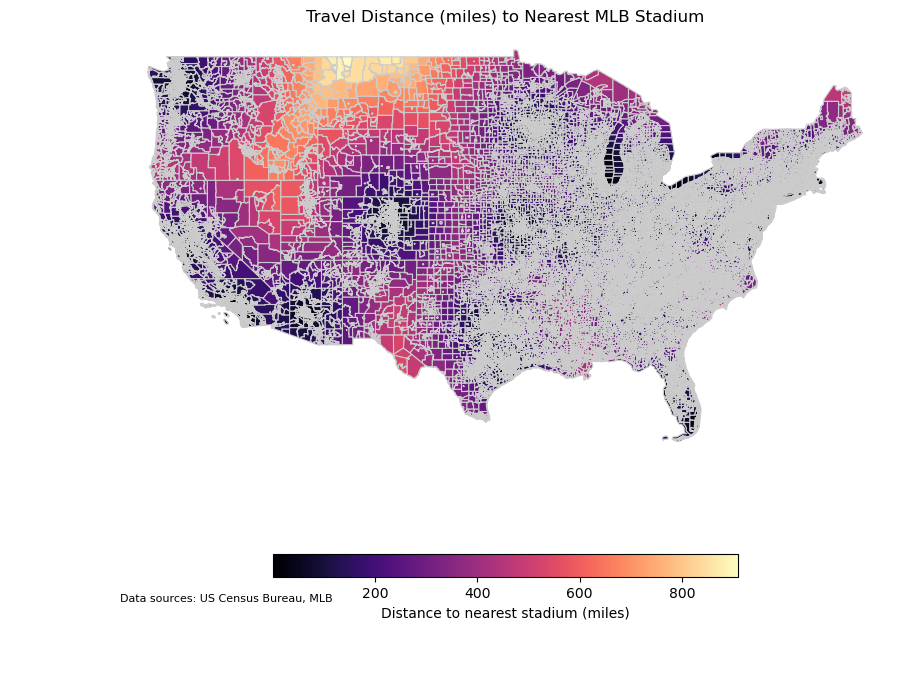

In [17]:
import matplotlib.pyplot as plt

# Add the distance to the GeoDataFrame
all_census_tracts['time'] = all_census_tracts['distance_to_stadium_miles']

# Plot the data
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
all_census_tracts.plot(column='time', cmap='magma', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True,
                       legend_kwds={'label': "Distance to nearest stadium (miles)",
                                    'orientation': "horizontal",
                                    'shrink': 0.5})

plt.title("Travel Distance (miles) to Nearest MLB Stadium")

# Annotate with data source
ax.annotate('Data sources: US Census Bureau, MLB', 
            xy=(0.1, 0.1), xycoords='figure fraction',
            fontsize=8, ha='left', va='top')

# Remove axis
ax.set_axis_off()

# Save the plot as a PNG file
plt.savefig('/Users/mitchellhamilton/m-r-ham.github.io/mitchymaps.github.io/projects/mlb-analysis/outputs/distance_to_stadiums.png', dpi=300)

# Show the plot
plt.show()